# AirBnB New User Bookings
****

**Mission of our project**:

* predict what will be the first destination users choose.
* What would the first destination be for new coming users?
* Is there any different preference based on the user’s gender or country of origin?
* What is the path to convert users from non-payers to payers?
* Which are the users likely to book again?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pylab as pl
import numpy as np
%matplotlib inline

In [2]:
age_gender = pd.read_csv('data/age_gender_bkts.csv')
countries = pd.read_csv('data/countries.csv')
sessions = pd.read_csv('data/sessions.csv')
train_users = pd.read_csv('data/train_users_2.csv')

# Data Wrangling
****

## First Glance into the datasets
****

When looking into new sets of data, it's important to understand what you can do with it and how much can you trust it, as well as how much of it does it need to be cleaned.

We want to look closer for:
* Missing Data
* Abnormalities in data
* Unusable formats

**Missing Data**
****

In [ ]:
#age_gender.head()
#countries.head()
#sessions.head()
#train_users.head()

* timestamp_first_active will have an unusual format, which we would need to look into to make it usable.
* gender has a lot of unknowns, which are being counted as "something" instead of "nothing". We need to clean up those values before moving on.

In [7]:
# Cleaning up nan's
train_users.replace("-unknown-", np.nan, inplace = True)
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


**timestamp_first_active** is quite unusual. I can only see that it's supposed to be an int64, but I can't tell how that is calculated as an int. Surely the first 8 numbers will represent the date. The simplest thing I can think of to solve this is to simply convert it to string and convert it into a usable format.

**date_acount_created** as well as date_first_booking are objects, which will make it difficult to compare dates between each other. these need to be converted as well

In [8]:
#converting timestamp objects to pandas timestamps for train_users

from datetime import datetime
new_timestamp = train_users.timestamp_first_active.astype(str)
dates = pd.to_datetime(pd.Series([datetime.strptime(date, '%Y%m%d%H%M%S') for date in new_timestamp]))

train_users['timestamp_first_active'] = dates
train_users['date_account_created'] = pd.to_datetime(train_users.date_account_created)
train_users['date_first_booking'] = pd.to_datetime(train_users.date_first_booking)
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,NaN,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Interesting to see that one column is missing in the test_users sample compared with the training sample. Still need to understand why is that. 

Right. that's happening because the column missing will be the targer column / variable which we will need to predict.

For less space taken up on the screen, we'll be colapsing the outputs, but we can always return to have a look, for a better idea of what we're dealing with

**Checking for abnormalities and possible unusable formats**
****

We should remember, when using the **train_users** dataframe:
* the fact that the date_first_booking will have a column filled with NaN's.
* the age column has only half of the rows with a valid age
* after cleaning up the dataframe, we notice that the gender column also has more than half of the observations with missing data
* first browser contains missing data as well. Fortunately we have first_device_type which might give some hints for our final problem
* date_first_booking is missing a lot of data, only ~42% of the observations will contain this information
* not all observations will have a first_affiliate_tracked

# Data Exploration
****

## A couple of questions that came up, as looking into the data.
****

* *Which country do most US American users opt for?*
* *What can we tell from the age of our users? Are all users above 18?*
* *Is there any trend in signups throughout time?*
* *Are all the click events correct or is it possible that some won't work incredibly well?*
* *Which are the devices these first bookings are being done?*
* *Can we find a correlation between the language these users speak and their country of destination?*

**Country of Destination**
*****

In [13]:
print "We'll have {0} of the total number of {1} of observations, which did not choose any destination.".format(train_users[train_users.country_destination == 'NDF'].shape[0], train_users.shape[0])
print "These observations represent {0:.2f}% of total.".format(float(train_users[train_users.country_destination == 'NDF'].shape[0])/float(train_users.shape[0])*100)

We'll have 124543 of the total number of 213451 of observations, which did not choose any destination.
These observations represent 58.35% of total.


In [14]:
df = train_users[train_users.country_destination != 'NDF']
df.country_destination.value_counts()

US       62376
other    10094
FR        5023
IT        2835
GB        2324
ES        2249
CA        1428
DE        1061
NL         762
AU         539
PT         217
Name: country_destination, dtype: int64

So, of the 41.65% of users left which did book a destination, the top destination was still US, while the first one in Europe (as far as we know) was France and Italy. Yay Latin language countries.

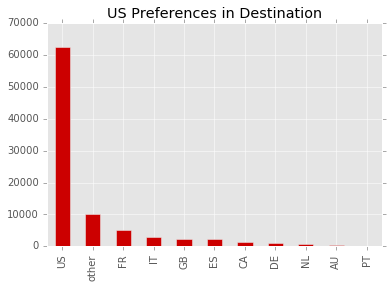

In [15]:
df.country_destination.value_counts().plot(kind = 'bar', color = '#cc0000')
pl.title("US Preferences in Destination")

* How many users have their timestamp before actually creating an account.

In [16]:
print "The training dataset will contain {0} users which have had their first activity before signing up.".format(df[df.date_account_created > df.timestamp_first_active].shape[0])
print "The training dataset will contain {0} users which have had their first booking before signing up.".format(df[df.date_account_created > df.date_first_booking].shape[0])
print "Training dataset contains {0} users".format(df.shape[0])

The training dataset will contain 124 users which have had their first activity before signing up.
The training dataset will contain 29 users which have had their first booking before signing up.
Training dataset contains 88908 users


* Is there anything these outliers have in common? 
    * is it possible that the device can be a problem?

In [17]:
outliers = pd.concat([df[df.date_account_created > df.timestamp_first_active],df[df.date_account_created > df.date_first_booking] ])
outliers.first_device_type.value_counts()

Mac Desktop        75
Windows Desktop    42
iPhone             17
iPad                8
Other/Unknown       4
Android Phone       3
Android Tablet      3
Desktop (Other)     1
Name: first_device_type, dtype: int64

    * are they relevant for our story? what is their country of destination?

In [18]:
outliers.country_destination.value_counts()

US       110
other     10
GB         8
IT         6
CA         5
DE         4
FR         4
ES         3
AU         2
NL         1
Name: country_destination, dtype: int64

I think it's safe to say we can drop the rows where this is happening, if we notice that it might affect any of our results. For now we'll keep it as so, but we should keep it in mind in case we see that it might affect some results

* **Age of users**
****

In [19]:
train_users.age.describe()
# ages = age_gender[['age_bucket','population_in_thousands']].groupby('age_bucket').sum().reset_index()
# ages.hist()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

It looks like some users confused age with the year of either when they were born, or when they created the account. We might consider trimming down the set to users which have less than 100 years. 

In [20]:
train_users[train_users.age < 100].age.describe()

count    123090.000000
mean         36.530937
std          11.673194
min           1.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64

Why do we have users which are underaged though? How many of those are there? We might want to consider getting those out.

In [21]:
train_users[train_users.age < 18].shape[0]

158

In [22]:
train_users[train_users.age < 18].country_destination.value_counts()

NDF      136
US        13
IT         2
GB         2
FR         2
DE         1
ES         1
other      1
Name: country_destination, dtype: int64

A lot of them did not seem to have made a booking, but even so, we might want to be careful. Is there anything in AirBnb's clauses that these users should be above 18? 

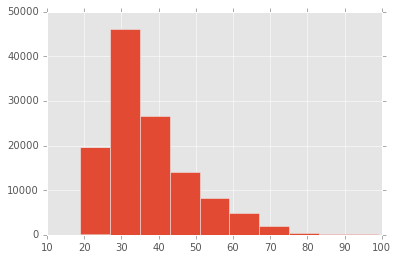

In [23]:
train_users[(train_users.age < 100) & (train_users.age > 18)].age.hist()

In [24]:
import scipy.stats as stats
stats.normaltest(train_users[(train_users.age < 100) & (train_users.age > 18)].age)

NormaltestResult(statistic=25178.69279014512, pvalue=0.0)

The visualisation may have told us that the distirbution is skewed. Before rulling it out, it's good to still check to be completely sure.
But given the results, since the statistic should have been under 8, we can conclude this is not a normal distribution.

* **Signups throughout time**
****

* based by day

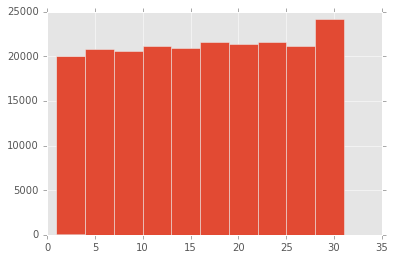

In [25]:
train_users.date_account_created.dt.day.hist()

There seems to be a slightly preferance for 30-31st of the month. Maybe it's because that's usually salary pay day?

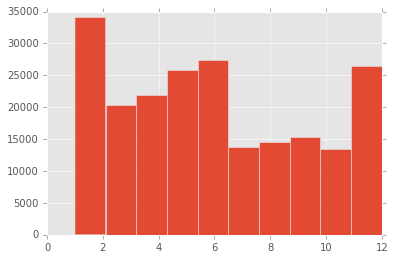

In [26]:
train_users.date_account_created.dt.month.hist()

New resolutions each year in January for travelling more in the year to come? 

Or maybe June stears up some need of adventure for the summer time.

And let's not forget that Christmas is always a great time to travel in new places. Would have expected everyone to travel back home to their parents though.

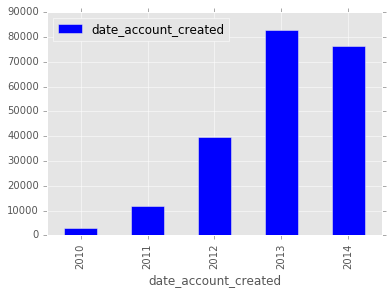

In [37]:
train_users[['date_account_created']].groupby(train_users.date_account_created.dt.year).count().plot(kind = 'bar')

But we know that 2014 does not have complete data regarding users. So we can expect to have even more data during 2014

* **Device Used**
****

Apple users will represent 60.48% of the total users.


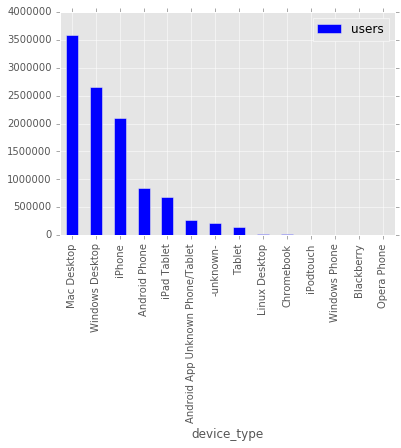

In [39]:
devices = pd.DataFrame(sessions.device_type.value_counts().reset_index())
devices.rename(columns = {'index':'device_type','device_type':'users'}, inplace = True)
devices.plot(x = 'device_type', y='users',kind= 'bar')

print "Apple users will represent {0:.2f}% of the total users."\
.format(float(devices[devices.device_type.isin(['Mac Desktop','iPhone','iPad Tablet','iPodtouch'])].users.sum()) / \
        float(devices.users.sum()) * 100)

So we can see that Apple users are already in our top users, given that Mac Desktop + iPhone would take up first places in Desktop and Mobile Devices. I wonder what happens if we look at Apple devices only, how much to they represent of the total? 